## Projeto Aprendizado de Máquina 2020.2
## Universidade Federal de Sergipe

### Professor
  - Hendrik Teixeira Macedo

### Alunos
  - Lucas Brabec Barreto Santana Matrícula: 201420014919
  - Mariana Lira de Farias Matrícula: 201700053220

In [ ]:
!nvidia-smi

Wed Jul 14 19:02:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -U mxnet-cu110==1.8.0 

     |████████████████████████████████| 315.4MB 51kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [ ]:
!pip install d2l

     |████████████████████████████████| 92kB 5.5MB/s 


Importando as Bibliotecas utilizadas

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
from mxnet import np, npx, nd, gluon, init, autograd
from sklearn.preprocessing import MinMaxScaler
from mxnet.gluon import nn, rnn
from d2l import mxnet as d2l

import numpy as np
import pandas as pd
import os

npx.set_np()

Repositório dos datasets utilizados


In [ ]:
data_dir = "https://raw.githubusercontent.com"
repo = "Brabec/dataset/master"

### Objetivos do Projeto
  Construir um modelo LSTM(_Long Short Term Memory_) para prever valores de:
      
      1. Ações AAPL(Apple)
      2. BTC(Bitcoin)
      3. USD Exchange Rate to BRL
      
### Metodologia de previsão
  Em todas as etapas de previsão utilizamos a previsão para t+1 valores e em seguida para 7, 15 e 30 valores à frente das amostras fornecidas para o modelo.

### Estudo de Caso 1 - Prevendo valores das ações da Apple(AAPL)
Disponível em: https://www.kaggle.com/faressayah/stock-market-analysis-prediction-using-lstm

A base de dados utiliza as amostras temporais entre 08/02/2013 e 07/02/2018

### Vizualização e Pré-processamento dos Dados

In [ ]:
filename = "S%26P%20500%20stock%20data/all_stocks_5yr.csv"
url = os.path.join(data_dir, repo, filename)
stocks = pd.read_csv(url, parse_dates=['date'], index_col='date')

stocks.head()

,open,high,low,close,volume,Name
date,,,,,,
2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


Selecionando as ações da Apple

In [ ]:
aapl = stocks[stocks['Name'] == 'AAPL'].iloc[:, :-1]
aapl

,open,high,low,close,volume
date,,,,,
2013-02-08,67.7142,68.4014,66.8928,67.8542,158168416
2013-02-11,68.0714,69.2771,67.6071,68.5614,129029425
2013-02-12,68.5014,68.9114,66.8205,66.8428,151829363
2013-02-13,66.7442,67.6628,66.1742,66.7156,118721995
2013-02-14,66.3599,67.3771,66.2885,66.6556,88809154
...,...,...,...,...,...
2018-02-01,167.1650,168.6200,166.7600,167.7800,47230787
2018-02-02,166.0000,166.8000,160.1000,160.5000,86593825
2018-02-05,159.1000,163.8800,156.0000,156.4900,72738522


In [ ]:
aapl.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2013-02-08 to 2018-02-07
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    1259 non-null   float64
 1   high    1259 non-null   float64
 2   low     1259 non-null   float64
 3   close   1259 non-null   float64
 4   volume  1259 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 99.0 KB


In [ ]:
aapl.describe()

,open,high,low,close,volume
count,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03
mean,109.055429,109.951118,108.141589,109.066698,5.404790e+07
std,30.549220,30.686186,30.376224,30.556812,3.346835e+07
min,55.424200,57.085700,55.014200,55.789900,1.147592e+07
25%,84.647800,85.334950,84.250650,84.830650,2.969438e+07
50%,108.970000,110.030000,108.050000,109.010000,4.566893e+07
75%,127.335000,128.100000,126.290000,127.120000,6.870872e+07
max,179.370000,180.100000,178.250000,179.260000,2.668336e+08


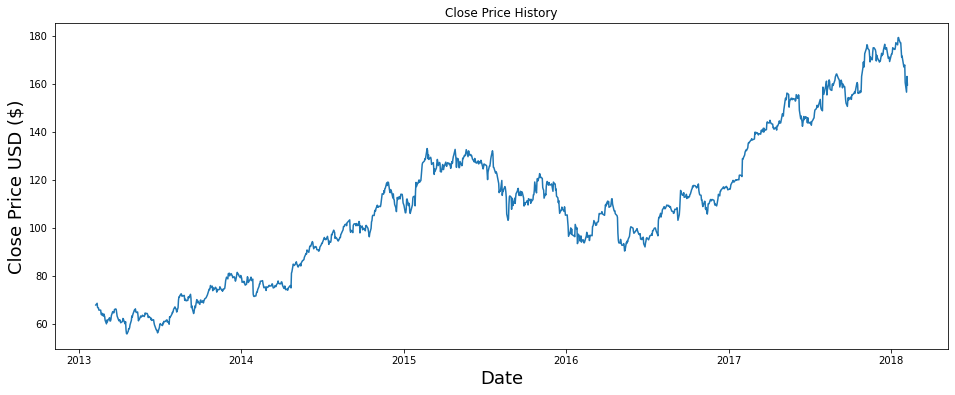

In [ ]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(aapl['close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

Preparação dos dados para a previsão


In [ ]:
def prepare_data(dataset, batch_size):

  len_train = int(len(dataset)*0.95)

  #Normalizando o dataset
  scaler = MinMaxScaler(feature_range=(0,1))
  dataset_scaled = scaler.fit_transform(dataset)

  train_data = np.array(dataset_scaled[0:int(len_train), :])
  test_data = np.array(dataset_scaled[len_train - 60:, :])

  #Preparando dataset de treino
  x_train = []
  y_train = []

  for i in range(60, len(train_data)):
      x_train.append(train_data[i-60:i, 0])
      y_train.append(train_data[i, 0])

  x_train = nd.array(x_train)
  y_train = nd.array(y_train)

  x_train = nd.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

  #Preparando Dataset de teste
  x_test = []
  y_test = dataset_scaled[len_train:, :]

  for i in range(60, len(test_data)):
      x_test.append(test_data[i-60:i, 0])

  x_test = nd.array(x_test)
  x_test = nd.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

  train_iter = d2l.load_array((x_train.as_np_ndarray(), y_train.as_np_ndarray()), batch_size)

  return scaler, train_iter, len_train, x_train, x_test, y_test


In [ ]:
dataset = aapl.filter(items=['close'])
batch_size = 10

scaler, train_iter, len_train, x_train, x_test, y_test = prepare_data(dataset, batch_size)

### Construção do Modelo e Treinamento


In [ ]:
def rmse_loss(net, data_iter, device):
    for i, (X, y) in enumerate(data_iter):
      X, y = X.as_in_ctx(device), y.as_in_ctx(device)
      y_hat = net(X)
      rmse = np.sqrt(np.mean(((y_hat - y) ** 2)))
    return rmse

In [ ]:
def train(net, trainer, train_iter, loss, epochs, lr, device):
    
    timer = d2l.Timer()
    for epoch in range(epochs):
        for X, y in train_iter:
            X, y = X.as_in_ctx(device), y.as_in_ctx(device)
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            d2l.grad_clipping(net, batch_size)
            trainer.step(batch_size)
        print(f'epoch {epoch + 1}, '
              f'loss: {rmse_loss(net, train_iter, device):f}')         
    timer.stop()
    
    print(f'Execution time: {timer.sum():.2f} seconds on {str(device)}')

Arquitetura da rede neuronal:

*   LSTM: 128 neurônios
*   LSTM: 64 neurônios
*   Camada Densa: 10 neurônios
*   Camada de saída: 1 neurônio



In [ ]:
def get_net():
  net = nn.Sequential()
  net.add(rnn.LSTM(128))
  net.add(rnn.LSTM(64))
  net.add(nn.Dense(25))
  net.add(nn.Dense(1))
  return net

loss = d2l.squared_loss

### Treinamento

  Primeiramente, seguimos os parâmetros originais do notebook¹:

    num_epochs: 1
    loss: mean_squared_error
    optimizer: adam

  Apesar de conseguirmos um baixíssimo valor de erro no conjunto de treinamento, obtivemos alto erro no conjunto de teste o que configura _overfitting_. Daí modificamos o hiperparâmetro num_epochs para 5, o que nos forneceu melhores resultados.

In [ ]:
net = get_net()

num_epochs, lr = 5, 0.01
device = d2l.try_gpu()
net.initialize(ctx=device, force_reinit=True, init=init.Xavier())
trainer = gluon.Trainer(net.collect_params(), 'adam',{'learning_rate': lr})

train(net, trainer, train_iter, loss, num_epochs, lr, device)

epoch 1, loss: 0.235864
epoch 2, loss: 0.255980
epoch 3, loss: 0.190511
epoch 4, loss: 0.315325
epoch 5, loss: 0.230451
Execution time: 11.50 seconds on gpu(0)


### Prevendo $t+k$ valores

  Previsão para 1 dia

In [ ]:
onestep_preds = net(x_test.as_np_ndarray().as_in_ctx(device))

predictions = scaler.inverse_transform(onestep_preds.asnumpy())

### Visualização da Previsão 

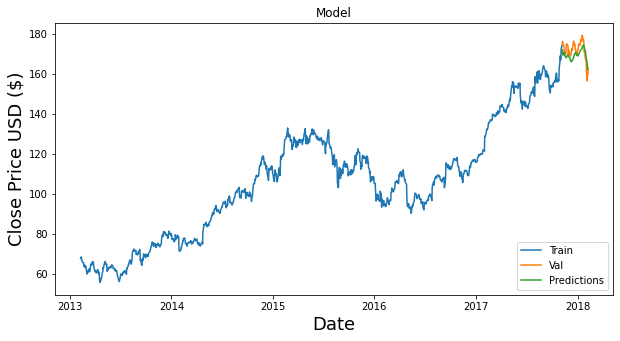

In [ ]:
train = dataset[:len_train]
valid = dataset[len_train:]
valid.insert(1, "predictions", predictions)


plt.figure(figsize=(10,5))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

Previsão para 1 semana, 15 dias e 1 Mês

In [ ]:
max_steps = 30
tau = 60 

x = nd.concat(x_train,x_test, dim=0)

preds = np.zeros((len(x) - tau - max_steps + 1, tau + max_steps))
items = preds

for i in range(tau):
    preds[:, i] = net(x[i:i + len(x) - tau - max_steps + 1].as_np_ndarray().as_in_ctx(device))

### Vizualização da Previsão

In [ ]:
def preview_preds(preds):
  pred_um = scaler.inverse_transform(preds[:,1].reshape(-1, 1))
  pred_sete = scaler.inverse_transform(preds[:,7].reshape(-1, 1))
  pred_quinze = scaler.inverse_transform(preds[:,15].reshape(-1, 1))
  pred_trinta = scaler.inverse_transform(preds[:,30].reshape(-1, 1))

  valid_seven = pd.DataFrame()
  valid_seven['predictions_one'] = pred_um.reshape(-1)
  valid_seven['predictions_seven'] = pred_sete.reshape(-1)
  valid_seven['predictions_fif'] = pred_quinze.reshape(-1)
  valid_seven['predictions_thirty'] = pred_trinta.reshape(-1)

  plt.figure(figsize=(16,6))
  plt.title('Model')
  plt.xlabel('Date', fontsize=15)
  plt.ylabel('Close Price USD ($)', fontsize=15)
  plt.plot(valid_seven['predictions_one'])
  plt.plot(valid_seven['predictions_seven'])
  plt.plot(valid_seven['predictions_fif'])
  plt.plot(valid_seven['predictions_thirty'])
  plt.legend(['Previsao t+1', 'Previsao t+7', 'Previsao t+15', 'Previsao t+30'], loc='lower right')
  plt.show()


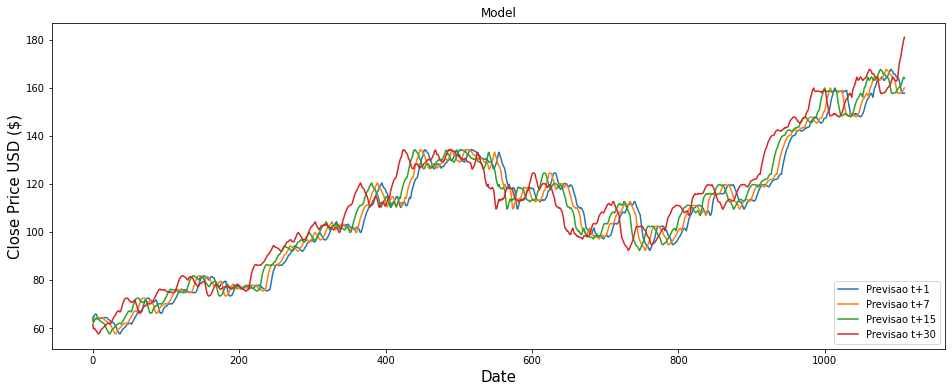

In [ ]:
preview_preds(preds)


###Estudo de Caso 2: Prevendo valores de bitcoin

Disponível em [Bitcoin Historical Dataset](https://www.kaggle.com/prasoonkottarathil/btcinusd?select=BTCUSD_day.csv)

A base de dados utiliza as amostras temporais entre 08/10/2015 e 10/04/2020

### Vizualização e Pré-processamento dos Dados

In [ ]:
filename = "bitcoin/BTCUSD_day.csv"
url = os.path.join(data_dir, repo, filename)

bitcoin = pd.read_csv(url, parse_dates=['Date'], index_col='Date')

bitcoin = bitcoin.filter(items=['Close'])
bitcoin['Date'] = bitcoin.index
bitcoin['order'] = list(range(len(bitcoin)))

bitcoin.set_index('order', inplace=True)
bitcoin.sort_index(ascending=False, inplace=True)

bitcoin.set_index('Date', inplace=True)

bitcoin.index = pd.to_datetime(bitcoin.index)

bitcoin

,Close
Date,
2015-10-08,243.95
2015-10-09,245.39
2015-10-10,246.30
2015-10-11,249.50
2015-10-12,247.60
...,...
2020-04-06,7336.96
2020-04-07,7201.81
2020-04-08,7369.60


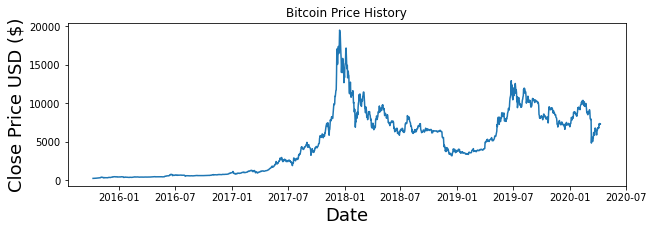

In [ ]:
plt.figure(figsize=(10,3))
plt.title('Bitcoin Price History')
plt.plot(bitcoin['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()


### Preparação dos dados para previsão

In [ ]:
scaler, train_iter, len_train, x_train, x_test, y_test = prepare_data(bitcoin, batch_size)

### Treinamento

In [ ]:

net.initialize(ctx=device, force_reinit=True, init=init.Xavier())
trainer = gluon.Trainer(net.collect_params(), 'adam',{'learning_rate': lr})

train(net, trainer, train_iter, loss, num_epochs, lr, device)

epoch 1, loss: 0.267273
epoch 2, loss: 0.162903
epoch 3, loss: 0.369825
epoch 4, loss: 0.218248
epoch 5, loss: 0.278893
Execution time: 10.31 seconds on gpu(0)


Previsão para um dia

In [ ]:
onestep_preds = net(x_test.as_np_ndarray().as_in_ctx(device))

predictions_bitcoin = scaler.inverse_transform(onestep_preds.asnumpy())

Visualização da Previsão

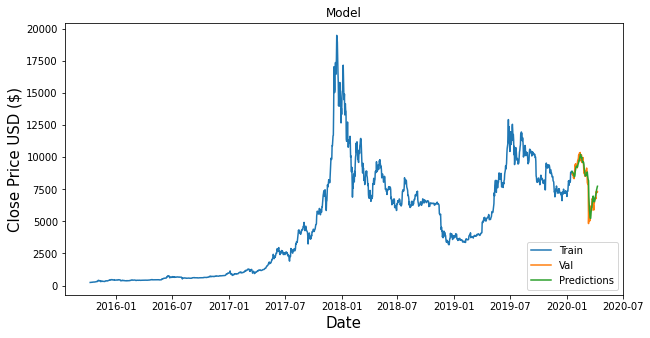

In [ ]:
train_bitcoin = bitcoin[:len_train]
valid_bitcoin = bitcoin[len_train:]
valid_bitcoin.insert(1, "pred_bitcoin", predictions_bitcoin)


plt.figure(figsize=(10,5))
plt.title('Model')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Close Price USD ($)', fontsize=15)
plt.plot(train_bitcoin['Close'])
plt.plot(valid_bitcoin[['Close', 'pred_bitcoin']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()


Previsão para 1 semana, 15 dias e 1 Mês

In [ ]:
max_steps = 30
tau = 60 

x_bitcoin = nd.concat(x_train,x_test, dim=0)

preds_bitcoin = np.zeros((len(x_bitcoin) - tau - max_steps + 1, tau + max_steps))

for i in range(tau):
    preds_bitcoin[:, i] = net(x_bitcoin[i:i + len(x_bitcoin) - tau - max_steps + 1].as_np_ndarray().as_in_ctx(device))


Visualização das Previsões

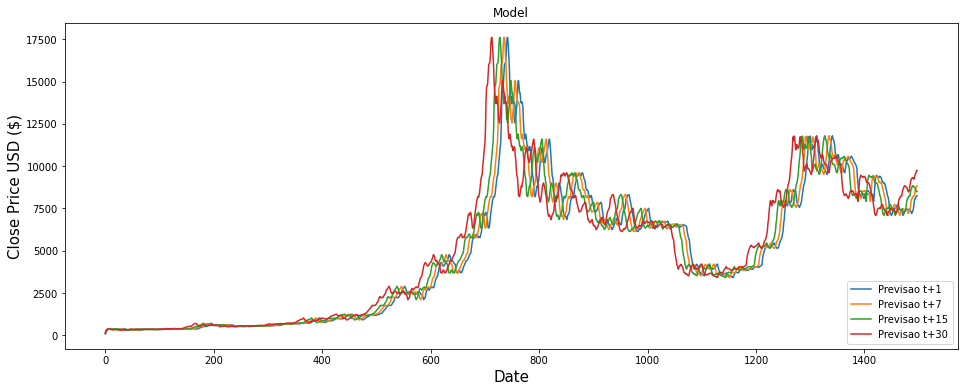

In [ ]:
preview_preds(preds_bitcoin)


### Estudo de caso (LSTM Time Serie - USD Exchange Rate)
  
  A base de dados utiliza as amostras temporais entre 03/01/2000 e 31/12/2019.
  
  Disponível em: [Foreign Exchange Rates 2000-2019](https://www.kaggle.com/brunotly/foreign-exchange-rates-per-dollar-20002019)

In [ ]:
filename = "usd-dataset/Foreign_Exchange_Rates.csv"
url = os.path.join(data_dir, repo, filename)
foreign_rates = pd.read_csv(url, parse_dates=['Time Serie'], index_col='Time Serie')
foreign_rates

,Unnamed: 0,AUSTRALIA - AUSTRALIAN DOLLAR/US$,EURO AREA - EURO/US$,NEW ZEALAND - NEW ZELAND DOLLAR/US$,UNITED KINGDOM - UNITED KINGDOM POUND/US$,BRAZIL - REAL/US$,CANADA - CANADIAN DOLLAR/US$,CHINA - YUAN/US$,HONG KONG - HONG KONG DOLLAR/US$,INDIA - INDIAN RUPEE/US$,KOREA - WON/US$,MEXICO - MEXICAN PESO/US$,SOUTH AFRICA - RAND/US$,SINGAPORE - SINGAPORE DOLLAR/US$,DENMARK - DANISH KRONE/US$,JAPAN - YEN/US$,MALAYSIA - RINGGIT/US$,NORWAY - NORWEGIAN KRONE/US$,SWEDEN - KRONA/US$,SRI LANKA - SRI LANKAN RUPEE/US$,SWITZERLAND - FRANC/US$,TAIWAN - NEW TAIWAN DOLLAR/US$,THAILAND - BAHT/US$
Time Serie,,,,,,,,,,,,,,,,,,,,,,,
2000-01-03,0,1.5172,0.9847,1.9033,0.6146,1.805,1.4465,8.2798,7.7765,43.55,1128,9.4015,6.126,1.6563,7.329,101.7,3.8,7.964,8.443,72.3,1.5808,31.38,36.97
2000-01-04,1,1.5239,0.97,1.9238,0.6109,1.8405,1.4518,8.2799,7.7775,43.55,1122.5,9.457,6.085,1.6535,7.218,103.09,3.8,7.934,8.36,72.65,1.5565,30.6,37.13
2000-01-05,2,1.5267,0.9676,1.9339,0.6092,1.856,1.4518,8.2798,7.778,43.55,1135,9.535,6.07,1.656,7.208,103.77,3.8,7.935,8.353,72.95,1.5526,30.8,37.1
2000-01-06,3,1.5291,0.9686,1.9436,0.607,1.84,1.4571,8.2797,7.7785,43.55,1146.5,9.567,6.08,1.6655,7.2125,105.19,3.8,7.94,8.3675,72.95,1.554,31.75,37.62
2000-01-07,4,1.5272,0.9714,1.938,0.6104,1.831,1.4505,8.2794,7.7783,43.55,1138,9.52,6.057,1.6625,7.2285,105.17,3.8,7.966,8.415,73.15,1.5623,30.85,37.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-25,5212,ND,ND,ND,ND,ND,ND,ND,ND,ND,ND,ND,ND,ND,ND,ND,ND,ND,ND,ND,ND,ND,ND
2019-12-26,5213,1.4411,0.9007,1.5002,0.7688,4.0602,1.3124,6.9949,7.788,71.28,1161.18,18.944,14.132,1.354,6.7295,109.67,4.1337,8.8799,9.4108,181.3,0.9808,30.11,30.15
2019-12-27,5214,1.4331,0.8949,1.4919,0.7639,4.0507,1.3073,6.9954,7.7874,71.45,1160.87,18.819,14.025,1.352,6.6829,109.47,4.126,8.8291,9.3405,181.35,0.9741,30.09,30.14


### Prevendo valores do dólar para o real

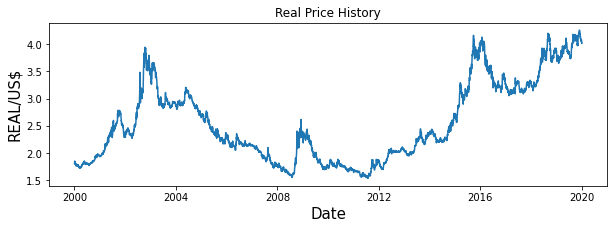

In [ ]:
# plot dataset
usd_dataset = foreign_rates.filter(items=['BRAZIL - REAL/US$'])

usd_dataset.index = pd.to_datetime(usd_dataset.index)

usd_dataset[usd_dataset == 'ND'] = np.nan
usd_dataset = usd_dataset.fillna(method='ffill') # filling NaN values with ffill parameter which propagates last valid observation to fill gaps

usd_dataset['BRAZIL - REAL/US$'] = pd.to_numeric(usd_dataset['BRAZIL - REAL/US$'])

plt.figure(figsize=(10,3))
plt.title('Real Price History')
plt.plot(usd_dataset['BRAZIL - REAL/US$'])
plt.xlabel('Date', fontsize=15)
plt.ylabel('REAL/US$', fontsize=15)
plt.show()

In [ ]:
scaler, train_iter, len_train, x_train, x_test, y_test = prepare_data(usd_dataset, batch_size)

### Treinando modelo

    Nesta tarefa alteramos a taxa de aprendizado, pois mostrou-se uma melhora na acurácia do modelo com lr = 0.001

In [ ]:
net = get_net()
num_epochs, lr = 10, 0.001
device = d2l.try_gpu()

net.initialize(ctx=device, force_reinit=True, init=init.Xavier())
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': lr})

train(net, trainer, train_iter, loss, num_epochs, lr, device)

epoch 1, loss: 0.300042
epoch 2, loss: 0.390338
epoch 3, loss: 0.279314
epoch 4, loss: 0.287419
epoch 5, loss: 0.240269
epoch 6, loss: 0.335126
epoch 7, loss: 0.374646
epoch 8, loss: 0.318475
epoch 9, loss: 0.318761
epoch 10, loss: 0.257552
Execution time: 68.20 seconds on gpu(0)


### Prevendo valores para $t+1$

In [ ]:
onestep_preds = net(x_test.as_np_ndarray().as_in_ctx(device))

predictions = scaler.inverse_transform(onestep_preds.asnumpy())

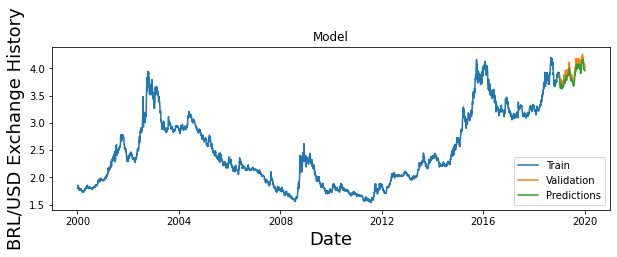

In [ ]:
train = usd_dataset[:len_train]
valid = usd_dataset[len_train:]
valid.insert(1, "predictions", predictions)

# Visualize the data
plt.figure(figsize=(10,3))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('BRL/USD Exchange History', fontsize=18)
plt.plot(train['BRAZIL - REAL/US$'])
plt.plot(valid[['BRAZIL - REAL/US$', 'predictions']])
plt.legend(['Train', 'Validation', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
valid

,BRAZIL - REAL/US$,predictions
Time Serie,,
2019-01-01,3.8804,3.847611
2019-01-02,3.8123,3.822905
2019-01-03,3.7429,3.784945
2019-01-04,3.7149,3.736574
2019-01-07,3.7100,3.697044
...,...,...
2019-12-25,4.0833,3.987749
2019-12-26,4.0602,3.992446
2019-12-27,4.0507,3.986443


### Previsão para 7, 15, 30 dias

In [ ]:
max_steps = 30
tau = 60 

x = nd.concat(x_train,x_test, dim=0)

preds = np.zeros((len(x) - tau - max_steps + 1, tau + max_steps))
items = preds

for i in range(tau):
    preds[:, i] = net(x[i:i + len(x) - tau - max_steps + 1].as_np_ndarray().as_in_ctx(device))

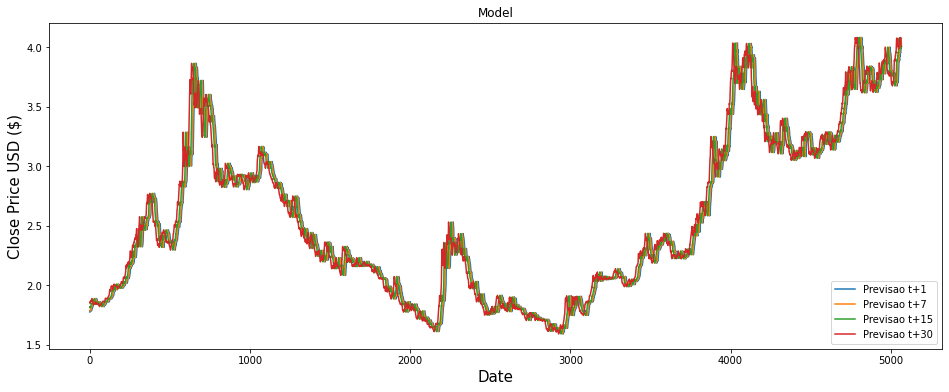

In [ ]:
preview_preds(preds)

### Referências

[1] Kaggle Notebook - [📊Stock Market Analysis 📈 + Prediction using LSTM](https://www.kaggle.com/faressayah/stock-market-analysis-prediction-using-lstm/log#6.-Predicting-the-closing-price-stock-price-of-APPLE-inc:)

[2] Kaggle Notebook - [Everything you can do with a time series](https://www.kaggle.com/thebrownviking20/everything-you-can-do-with-a-time-series/notebook)